# Basic Import

In [1]:
import numpy as np
import meshio
import os
import tensorflow as tf

In [2]:
import pyvista as pv

# Example of a simple mesh

In [3]:
mesh_path = 'shapes/shape_1_1_0.vtu'

### We can check the mesh with pyvista or paraview. Here we chose pyvista to stay in a notebook.

In [4]:
mesh_pv = pv.read(mesh_path)

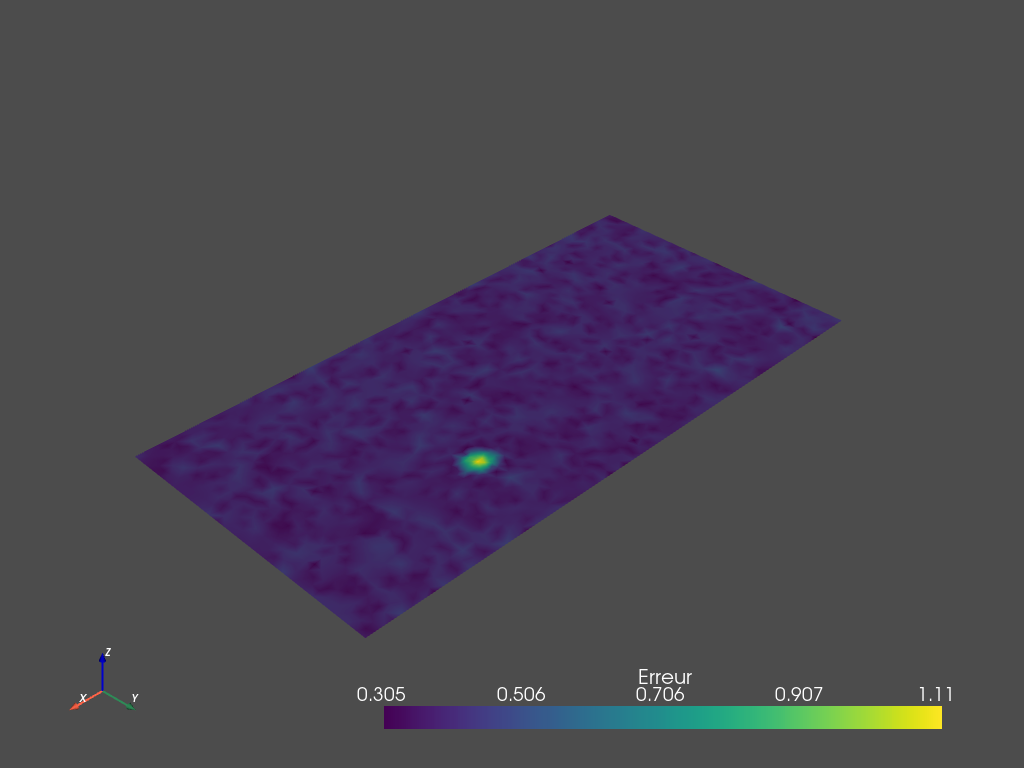

[(29.94009759259467, 24.94009759259467, 24.94009759259467),
 (5.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [5]:
mesh_pv.plot(show_scalar_bar=True, show_axes=True, notebook = True,show_edges=False)

# Gradient

Let's compute the gradient of this field on this unstructured mesh. We first need to compute (and store to reuse them later) gradient matrix.

In [6]:
mesh = meshio.read(mesh_path,"vtu")

In [7]:
from meshgradient.matrix import build_CON_matrix, build_PCE_matrix, build_AGS_matrix

In [8]:
%time test = build_CON_matrix(mesh)
print()
print('-'*10)
print()
print("Gradient Matrix as a Tensorflow Sparse Tensor: ")
print()
print(test)
print()
print('-'*10)
print()

CPU times: user 957 ms, sys: 10.5 ms, total: 967 ms
Wall time: 977 ms

----------

Gradient Matrix as a Tensorflow Sparse Tensor: 

SparseTensor(indices=tf.Tensor(
[[   0 1034]
 [   0 4295]
 [   1 1209]
 ...
 [2254 1820]
 [2254 2874]
 [2254 2879]], shape=(13026, 2), dtype=int64), values=tf.Tensor([0.49501204 0.50498796 0.4686343  ... 0.17672244 0.17399704 0.14961846], shape=(13026,), dtype=float32), dense_shape=tf.Tensor([2255 4342], shape=(2,), dtype=int64))

----------



Note that while we used these matrix to perform machine learning training within Tensorflow, you can replace these tensorflow Sparse tensors with any other sparse matrix of your choice.

Let's build and save our 3 gradient matrix: 

In [9]:
import pickle
def build_and_save_gradient_matrix(mesh,gradient_folder,gradient_filename):
  tf_gradient_matrix = build_AGS_matrix(mesh)
  with open(os.path.join(gradient_folder,'AGS_' + gradient_filename), 'wb') as handle:
    pickle.dump(tf_gradient_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

  tf_gradient_matrix = build_PCE_matrix(mesh)
  with open(os.path.join(gradient_folder,'PCE_' + gradient_filename), 'wb') as handle:
    pickle.dump(tf_gradient_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

  tf_gradient_matrix = build_CON_matrix(mesh)
  with open(os.path.join(gradient_folder,'CON_' + gradient_filename), 'wb') as handle:
    pickle.dump(tf_gradient_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
build_and_save_gradient_matrix(mesh, 'shapes','example_gradient')

Let's use these matrix to compute our gradients. First we load the 3 tensor and then we use our built in functions to compute the gradient.

In [11]:
def load_gradient_matrix(gradient_folder,gradient_filename):
  with open(os.path.join(gradient_folder,'AGS_' + gradient_filename), 'rb') as handle:
    tf_AGS_matrix = pickle.load(handle)

  with open(os.path.join(gradient_folder,'PCE_' + gradient_filename), 'rb') as handle:
    tf_PCE_matrix = pickle.load(handle)

  with open(os.path.join(gradient_folder,'CON_' + gradient_filename), 'rb') as handle:
    tf_CON_matrix = pickle.load(handle)
  return tf_AGS_matrix, tf_PCE_matrix, tf_CON_matrix

In [12]:
gradient_matrix = load_gradient_matrix('shapes','example_gradient')

We will use 4 boundaries for the 4 sides of our cavity, and compute the gradient of the field "Erreur": 

In [13]:
b1,b2,b3,b4 = mesh.point_data['AppartientEntree1'],mesh.point_data['AppartientEntree2'],mesh.point_data['AppartientEntree3'],mesh.point_data['AppartientEntree4']

In [14]:
erreur_field = mesh.point_data['Erreur']

Let's import one of our function: 

In [15]:
from meshgradient.gradient_fn import compute_gradient_per_points

In [16]:
gradient_erreur = compute_gradient_per_points(gradient_matrix,erreur_field,b1,b2,b3,b4)

In [17]:
gradient_erreur

<tf.Tensor: shape=(2255, 3), dtype=float32, numpy=
array([[-0.04144194, -0.1458799 ,  0.        ],
       [-0.08990717,  0.01572272,  0.        ],
       [ 0.07131144, -0.1060261 ,  0.        ],
       ...,
       [ 0.09101892, -0.01499036,  0.        ],
       [ 0.10301885, -0.047701  ,  0.        ],
       [-0.00888862,  0.01596028,  0.        ]], dtype=float32)>

Let's add this field to our mesh, and display it (or compare it in paraview with the built in gradient from paraview).

In [25]:
mesh.point_data['Erreur'] = gradient_erreur.numpy()
meshio.write('shapes/shape_with_gradient.vtu',mesh)

In [26]:
mesh_pv = pv.read('shapes/shape_with_gradient.vtu')

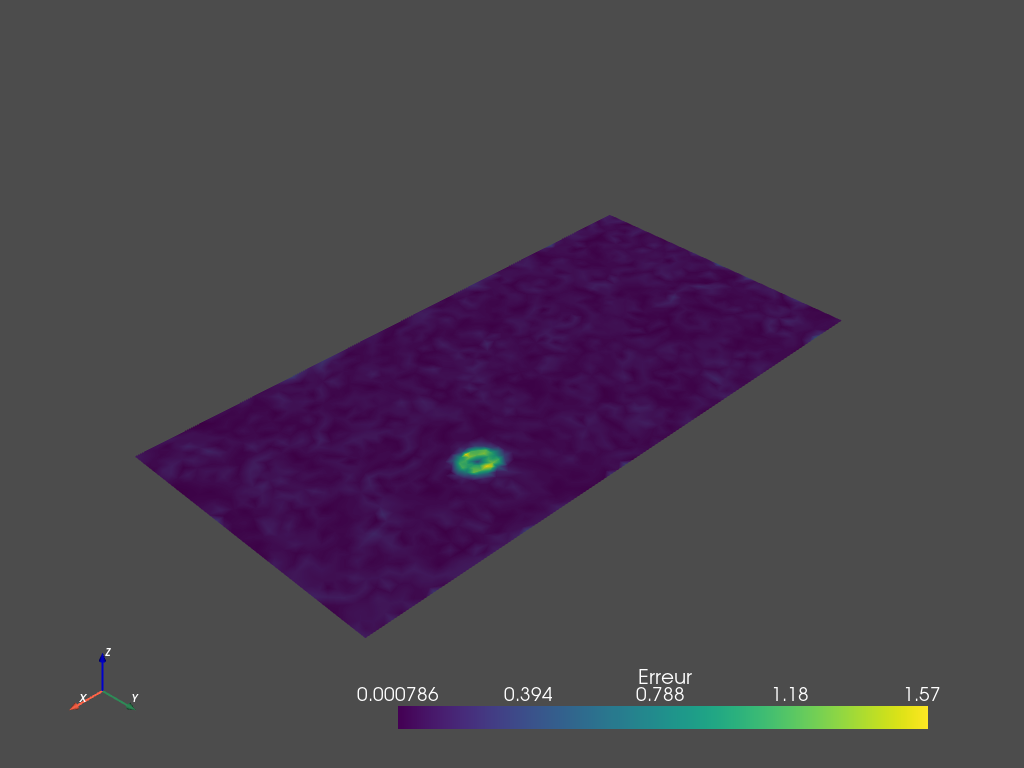

[(29.94009759259467, 24.94009759259467, 24.94009759259467),
 (5.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [29]:
mesh_pv.plot(show_axes=True, notebook = True,show_edges=False)